# Face Generation
In this project, we'll use generative adversarial networks to generate new images of faces.
### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex we want 
to first test the neural network on MNIST before CelebA.  Running the GANs on MNIST allows us to see how well the model trains sooner.

In [1]:
data_dir = 'data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

  Using cached https://files.pythonhosted.org/packages/2c/69/362c0a5eca37225c7d451e6c57f07c4fee85a5b6cb3aedf16fe649f411ea/matplotlib-2.0.2-cp27-cp27mu-manylinux1_x86_64.whl
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python2.7/dist-packages/matplotlib-2.1.0-py2.7-nspkg.pth'
Consider using the `--user` option or check the permissions.

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
We know that the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. We can view the first number of examples by changing `show_n_images`. 

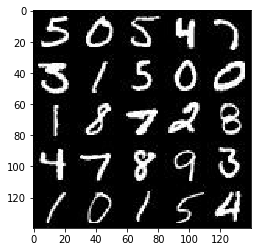

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  We can view the first number of examples by changing `show_n_images`.

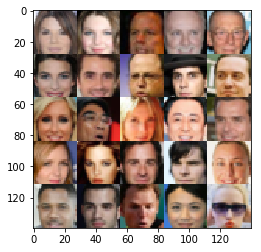

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
We'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure we have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implemented the `model_inputs` function to create TF Placeholders for the Neural Network. It creates the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return (inputs,z_inputs, learning_rate)

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implemented `discriminator` to create a discriminator neural network that discriminates on `images`.  This function will be able to reuse the variables in the neural network. Used [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function returns a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.5
    with tf.variable_scope('discriminator',reuse=reuse):
        #input layer is 28*28*3
#         print(images.shape)
        x1 = tf.layers.conv2d(images, 64, 5, strides= 1, padding='valid')
        relu1 = tf.maximum(alpha*x1, x1)
#         print(x1.shape)
        # 24*24*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.layers.dropout(x2, rate=keep_prob)
        relu2 = tf.maximum(alpha*x2, x2)        
        #12*12*128
#         print(x2.shape)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.layers.dropout(x3, rate=keep_prob)
        relu3 = tf.maximum(alpha * x3, x3)
#         print(x3.shape)
        #6*6*256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.layers.dropout(x4, rate=keep_prob)
        relu4 = tf.maximum(alpha * x4, x4)
#         print(x4.shape)
        #3*3*512
        
        flat = tf.reshape(relu4,(-1, 3*3*512))
#         print(flat.shape)
        logits= tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
        return (output, logits)

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implemented `generator` to generate an image using `z`. This function will be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function will return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.5
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 3*3*512)
#         print(x1.shape)
        x1 = tf.reshape(x1, (-1 , 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=keep_prob)
#         print(x1.shape)
        #3*3*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2 , x2)
        x1 = tf.layers.dropout(x2, rate=keep_prob)
#         print(x2.shape)
        #6*6*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        x1 = tf.layers.dropout(x3, rate=keep_prob)
#         print(x3.shape)
        #12*12*128

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4,x4)
#         x1 = tf.layers.dropput(x4, rate=keep_prob)
#         print(x4.shape)
        #24*24*64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='valid')
#         print(logits.shape)
        #28*28*5
        output = tf.tanh(logits)    
        return output

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implementex `model_loss` to build the GANs for training and calculate the loss.  The function returns a tuple of (discriminator loss, generator loss).  Used the following functions we implemented earlier:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implemented `model_opt` to create the optimization operations for the GANs. Used d[`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filtered the variables with names that are in the discriminator and generator scope names.  The function returns a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Output
Now it's time to use this function to show the current output of the generator during training. It will help us determine how well the GANs is training.

In [10]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implemented `train` to build and train the GANs.  Used the following functions we implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Used the `show_generator_output` to show `generator` output while we train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     tf.reset_default_graph()
#     print(data_shape)
    _, image_width, image_height, image_channels = data_shape[0], data_shape[1], data_shape[2], data_shape[3]

    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    show_every = 100
    print_every = 25
    steps = 0
    n_images = 25

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # To rescale images
                x = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: x, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: x, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

#     return losses, samples

### MNIST
Time to test GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Loss of the generator should be lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.9405... Generator Loss: 0.1169
Epoch 1/2... Discriminator Loss: 0.3793... Generator Loss: 4.0701
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 4.2293
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 2.8830


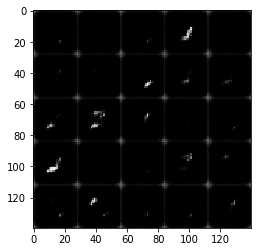

Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 2.2966
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 1.4207
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 1.4083
Epoch 1/2... Discriminator Loss: 1.0858... Generator Loss: 2.1137


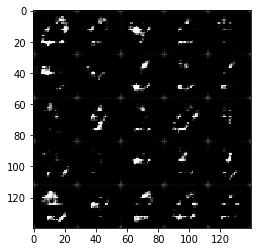

Epoch 1/2... Discriminator Loss: 2.6771... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 3.5472
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 2.0926
Epoch 1/2... Discriminator Loss: 0.8743... Generator Loss: 1.6237


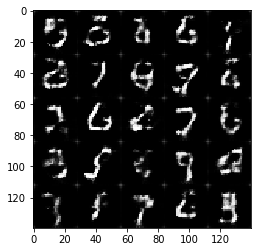

Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 1.9851
Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.7135
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 2.1982


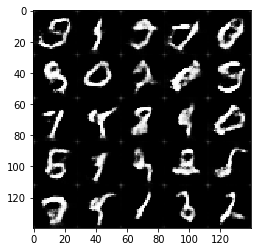

Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 2.5102
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 1.5323


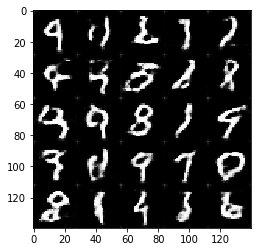

Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.5232
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 2.0195


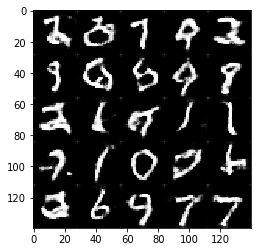

Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 1.9313... Generator Loss: 3.2343
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 1.5983
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.3182


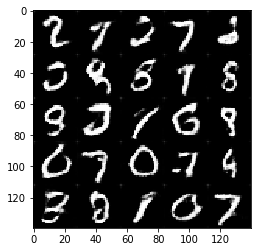

Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 1.5917... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.9567


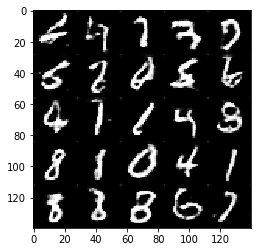

Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.6413
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 0.8350... Generator Loss: 1.7096
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 2.2441


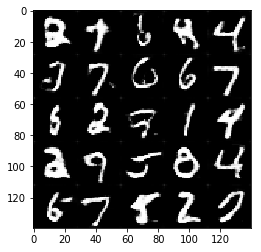

Epoch 2/2... Discriminator Loss: 1.8474... Generator Loss: 0.4708


In [18]:
batch_size = 128 
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Now we run GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  We can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.3783
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 3.0422
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 5.4895


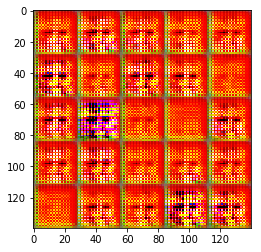

Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 5.0320
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 4.9442
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 5.7394


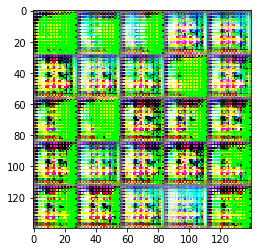

Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.7948... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 2.6579


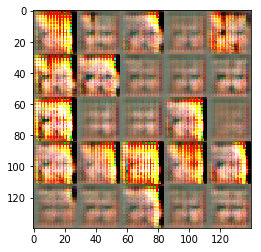

Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 3.8197
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9922


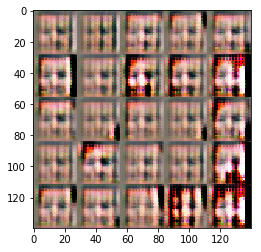

Epoch 1/1... Discriminator Loss: 2.0782... Generator Loss: 0.2581
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 1.1138


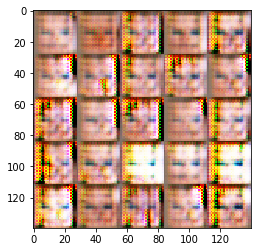

Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.2066
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 1.1088


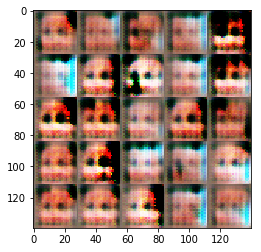

Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8214


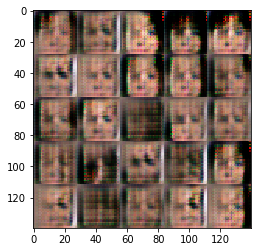

Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.8849


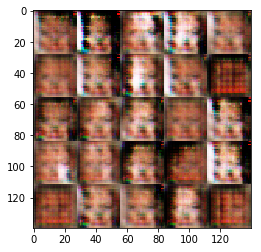

Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.9195
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8777


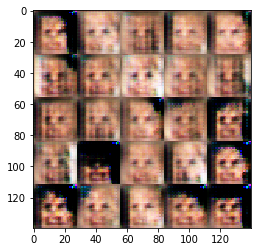

Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.3695


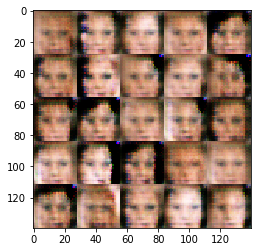

Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 2.4650
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 2.4308
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 2.2107


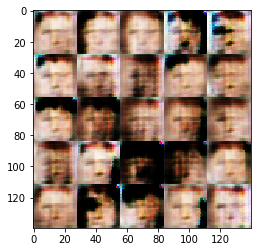

Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.7775


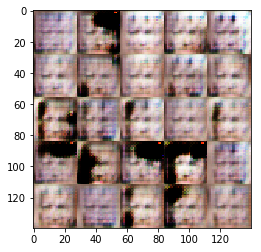

Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 2.2135
Epoch 1/1... Discriminator Loss: 1.9479... Generator Loss: 3.7203
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.2148


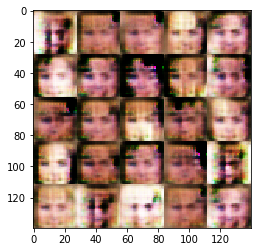

Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.8701
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.1805


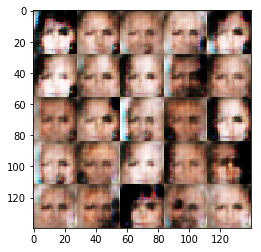

Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.6606
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.4075


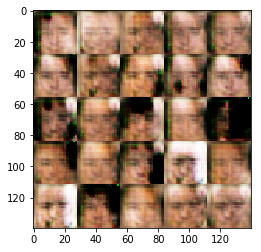

Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.9998
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.3522


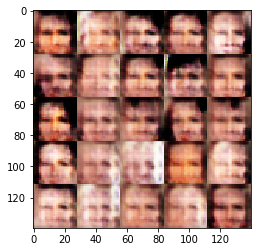

Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 1.5924
Epoch 1/1... Discriminator Loss: 2.0409... Generator Loss: 3.5611
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.5694


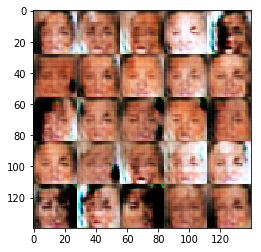

Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 3.1490
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 1.8110
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.2812


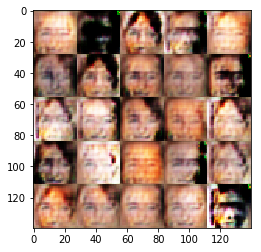

Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 2.1295
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 2.0320
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 2.3850
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.0621


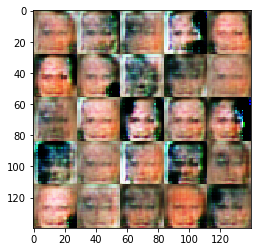

Epoch 1/1... Discriminator Loss: 1.8094... Generator Loss: 0.3540
Epoch 1/1... Discriminator Loss: 4.0555... Generator Loss: 0.0326
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.7736
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.3280


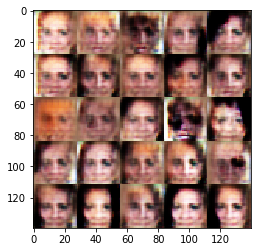

Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.5802
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7515


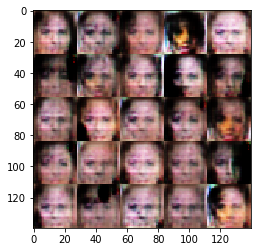

Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.5646
Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 2.1677
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 2.3421
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 2.4768


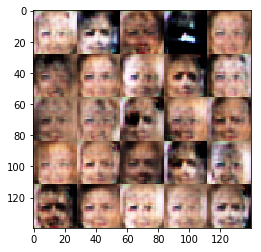

Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 2.0752
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.2334


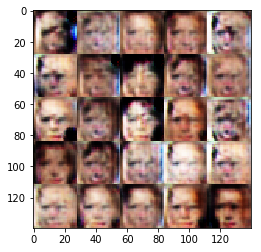

Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.8078
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 2.6730... Generator Loss: 0.2138
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.6072


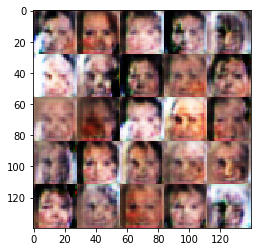

Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 2.1029
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 1.9915
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.8230


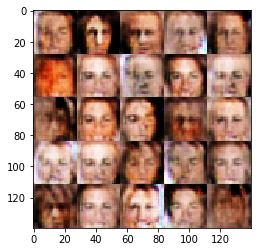

Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.9760
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.1280


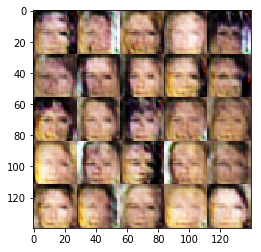

Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 2.1461
Epoch 1/1... Discriminator Loss: 2.6193... Generator Loss: 6.4035
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 2.3170


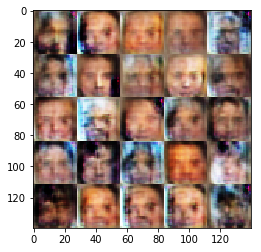

Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.8789
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 1.8925
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 2.4073
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 2.8225


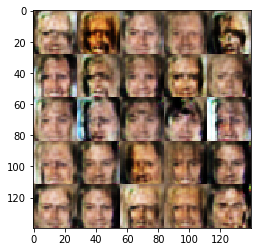

Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.6202
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.9664
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.1386


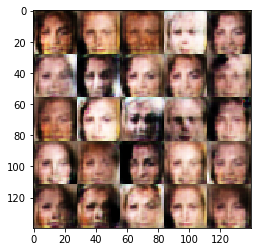

Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 3.6839
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.1524


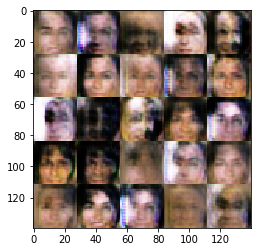

Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 2.9534
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 2.0325


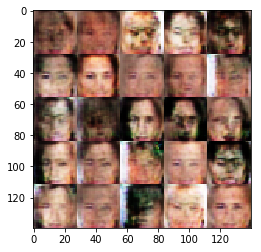

Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.2906
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 2.0148
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.9589


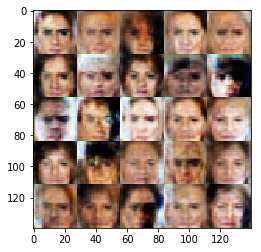

Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 1.8638
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.5536


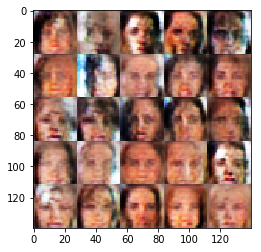

Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 4.2156
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 2.0649
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.8006


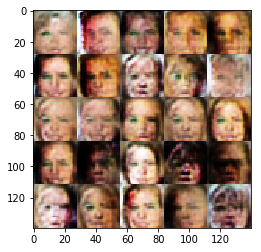

Epoch 1/1... Discriminator Loss: 1.9391... Generator Loss: 0.3207
Epoch 1/1... Discriminator Loss: 0.6198... Generator Loss: 1.7723
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.8221


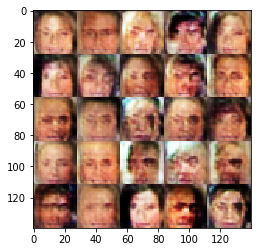

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.3454
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.1378


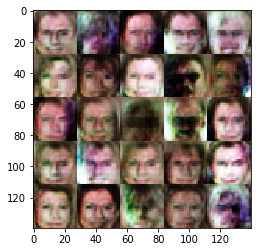

Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 2.8255
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 2.0085
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9629


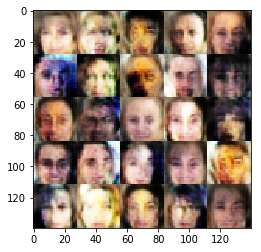

Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 2.0049


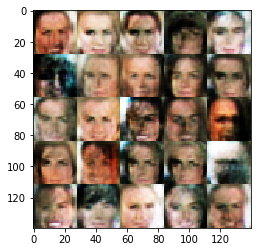

Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 2.1480
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 1.7715
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.1025


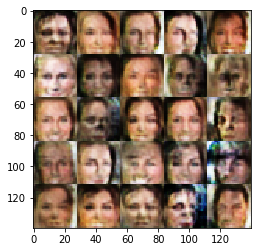

Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.9166
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.6476
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.5602


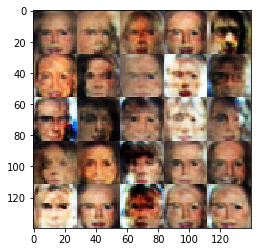

Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 2.4250
Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.6493


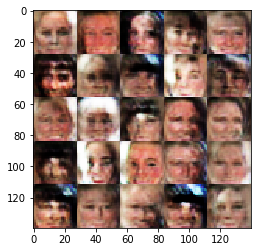

Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 2.3336... Generator Loss: 0.2037
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 3.0062


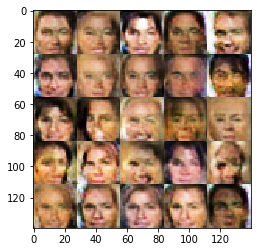

Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 2.7069
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.0796


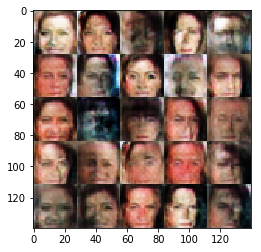

Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.5890
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.3080


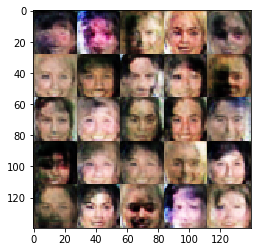

Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 3.0270
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 1.9845
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.7574
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.8874


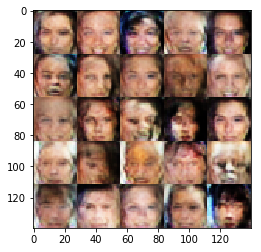

Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 2.5091
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.0613


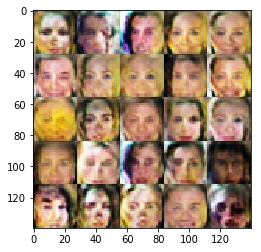

Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 2.2266
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.1326


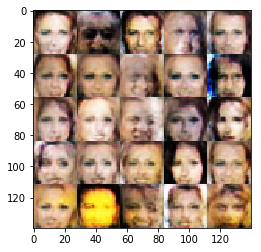

Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.9158
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.6509
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 4.4098


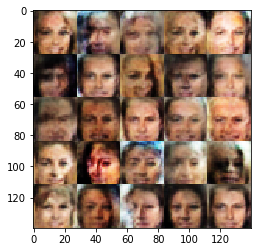

Epoch 1/1... Discriminator Loss: 2.0441... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.7222
Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 1.7364


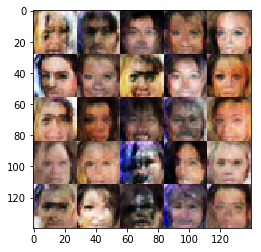

Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 2.1609
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.9988


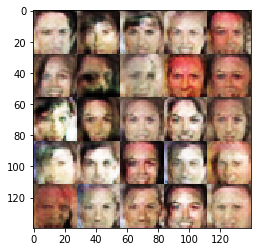

Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 0.9221


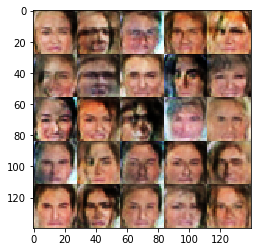

Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 2.0309
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 3.0847


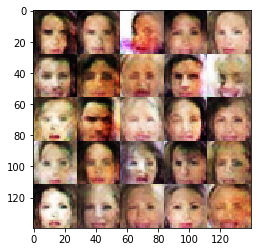

Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.6783
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 1.8880


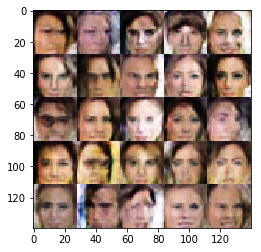

Epoch 1/1... Discriminator Loss: 2.0522... Generator Loss: 0.2729
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 2.5416
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.6422
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.8271


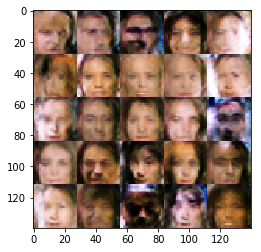

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.8863


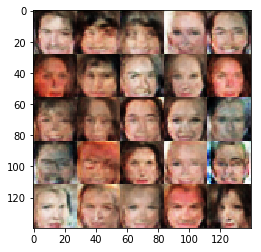

Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 1.8634
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 3.5946
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 1.8412


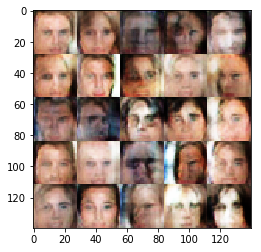

Epoch 1/1... Discriminator Loss: 1.7264... Generator Loss: 0.3833
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 4.6471


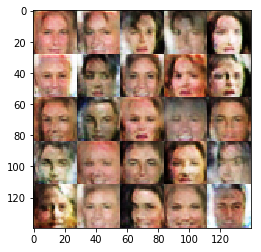

Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.9015
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 2.6232
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.4133


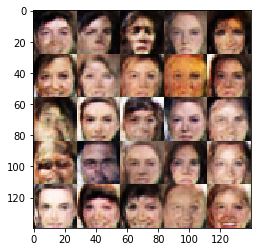

Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 4.0210
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.9054


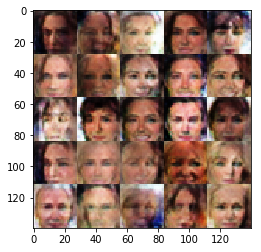

Epoch 1/1... Discriminator Loss: 2.5253... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 2.0623... Generator Loss: 0.2575
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.8931


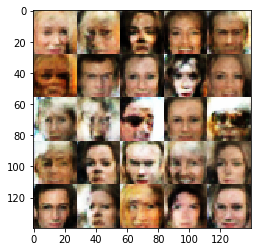

Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 2.5027


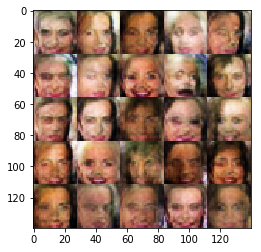

Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 1.7775
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 2.8148
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.8756


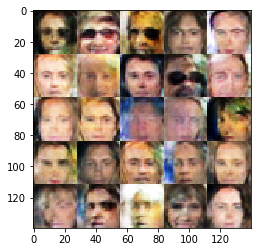

Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 2.3948... Generator Loss: 0.2260
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.1413


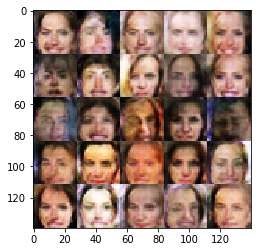

Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 2.0536
Epoch 1/1... Discriminator Loss: 1.7987... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.6469


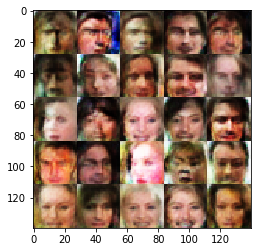

Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 2.9681
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.9064
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.0619


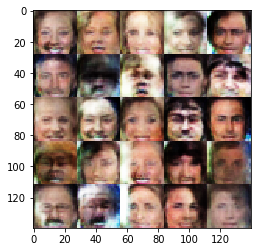

Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 2.4473
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 2.0987


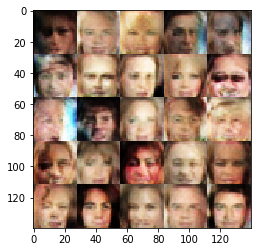

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 5.4583
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 2.4401... Generator Loss: 0.1720
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.2791


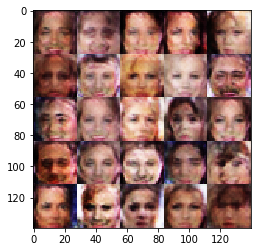

Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.4985


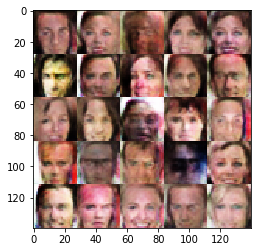

Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 2.6986... Generator Loss: 0.1927
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 3.1943


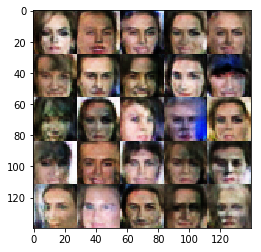

Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.7712


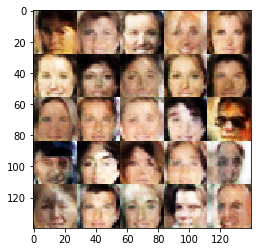

Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.7467... Generator Loss: 0.3151
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 4.0850
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.1152


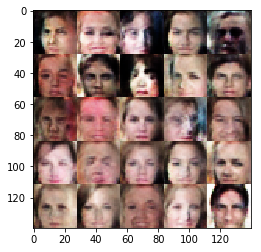

Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.3707
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.4726
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.6764


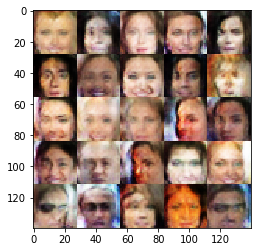

Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 2.7947
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 1.9828
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 2.2370


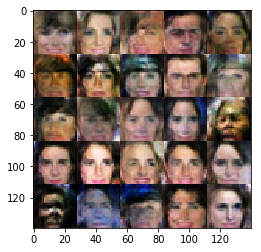

Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 2.6224
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.9449... Generator Loss: 0.3260
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.7734


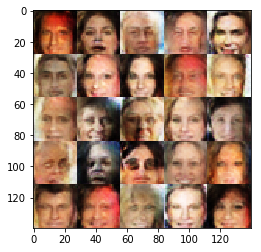

Epoch 1/1... Discriminator Loss: 2.3120... Generator Loss: 0.2059
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 3.1956
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 1.8587


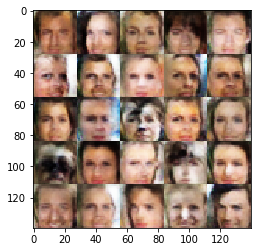

Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 1.9734
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.6397
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 2.0899... Generator Loss: 0.2442


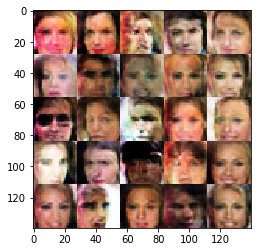

Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 1.9845
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 2.4430
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.5335


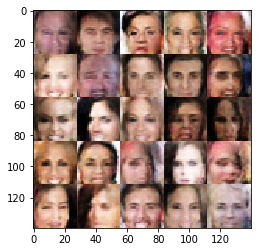

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.9500
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.0780


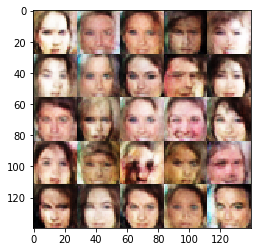

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 3.8537


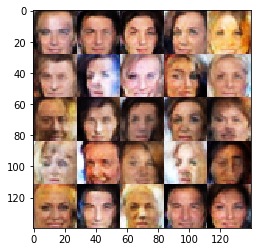

Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.3200
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 2.6421


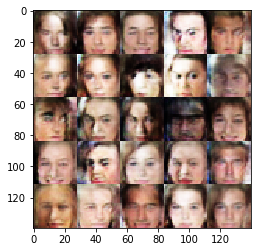

Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.9500
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.7941
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.4207


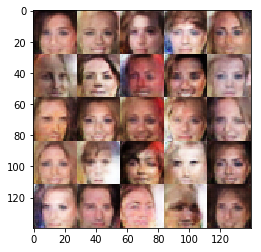

Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 1.8784
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 3.1014


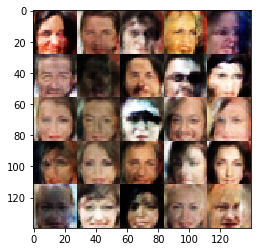

Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.7361
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.0284


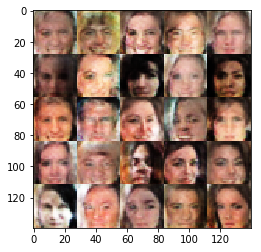

Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 2.1748
Epoch 1/1... Discriminator Loss: 1.7416... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.9443
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.9389


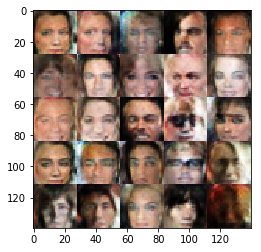

Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.8808


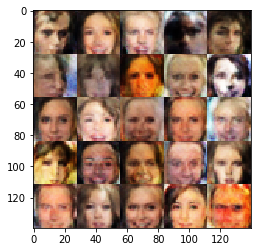

Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 3.8348
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.6853
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.9938
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 2.7495


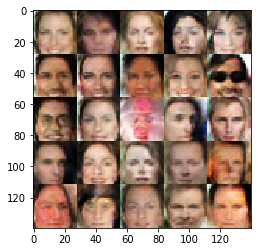

Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 2.3335
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.9862
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.5125


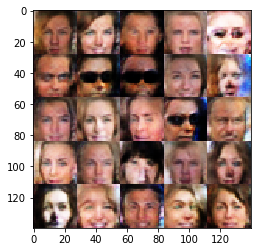

Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.6004
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6471


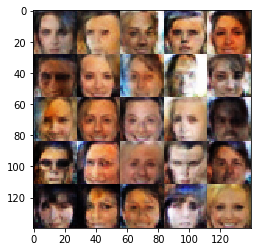

Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 1.9375
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 5.1569
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6155


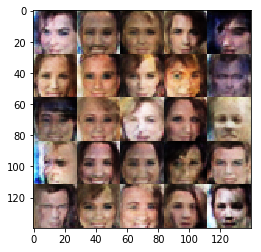

Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 2.6386... Generator Loss: 0.1547


In [17]:
batch_size = 16
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)